# Dataset preparation

The main purpose of this notebook - prepare convenient way to work with dataset. I think, the best way - using pandas DataFrame

In [73]:
import os
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2

## Dataset path

In [2]:
data_path = './Data/'

In [38]:
classes = os.listdir(data_path)
print('Total classes: {}'.format(len(classes)))

Total classes: 1000


## Generate list of train files

In [39]:
classes_df = []
for c in classes:
    path = os.path.join(data_path, c)
    samples = os.listdir(path)
    input_files = list(filter(lambda x: os.path.splitext(x)[-1] == '.jpg', samples))
    output_files = list(filter(lambda x: os.path.splitext(x)[-1] == '.png', samples))
    input_output_pairs = []
    for in_name in input_files:
        name = os.path.splitext(in_name)[0]
        out_name = name+'.png'
        if out_name in output_file:
            input_output_pairs.append((os.path.join(path, in_name), os.path.join(path, out_name)))
        else:
            print('File {} has not mask file'.format(os.path.join(path, in_name)))
            
    files = list(zip(*input_output_pairs))
    in_files, out_files = files[0], files[1]
    df = pd.DataFrame(data={'in_file': in_files, 'out_file': out_files, 'class': [c]*len(in_files) })
    classes_df.append(df)

final_df = pd.concat(classes_df)
final_df.sample(4)

class                         in_file  \
8  sulphur_butterfly  ./Data/sulphur_butterfly/9.jpg   
9              tiger              ./Data/tiger/5.jpg   
3        poached_egg        ./Data/poached_egg/7.jpg   
9           strainer           ./Data/strainer/5.jpg   

                         out_file  
8  ./Data/sulphur_butterfly/9.png  
9              ./Data/tiger/5.png  
3        ./Data/poached_egg/7.png  
9           ./Data/strainer/5.png

In [40]:
match_names_mask = final_df.apply(lambda r: os.path.splitext(r['in_file'])[0] == os.path.splitext(r['out_file'])[0], axis=1)
print('All files match names: {}'.format(all(match_names_mask)))

All files match names: True


## Check if masks are valid

Prepare transparent cmap

In [74]:
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

plt.register_cmap(cmap=map_object)

Plot samples with mask

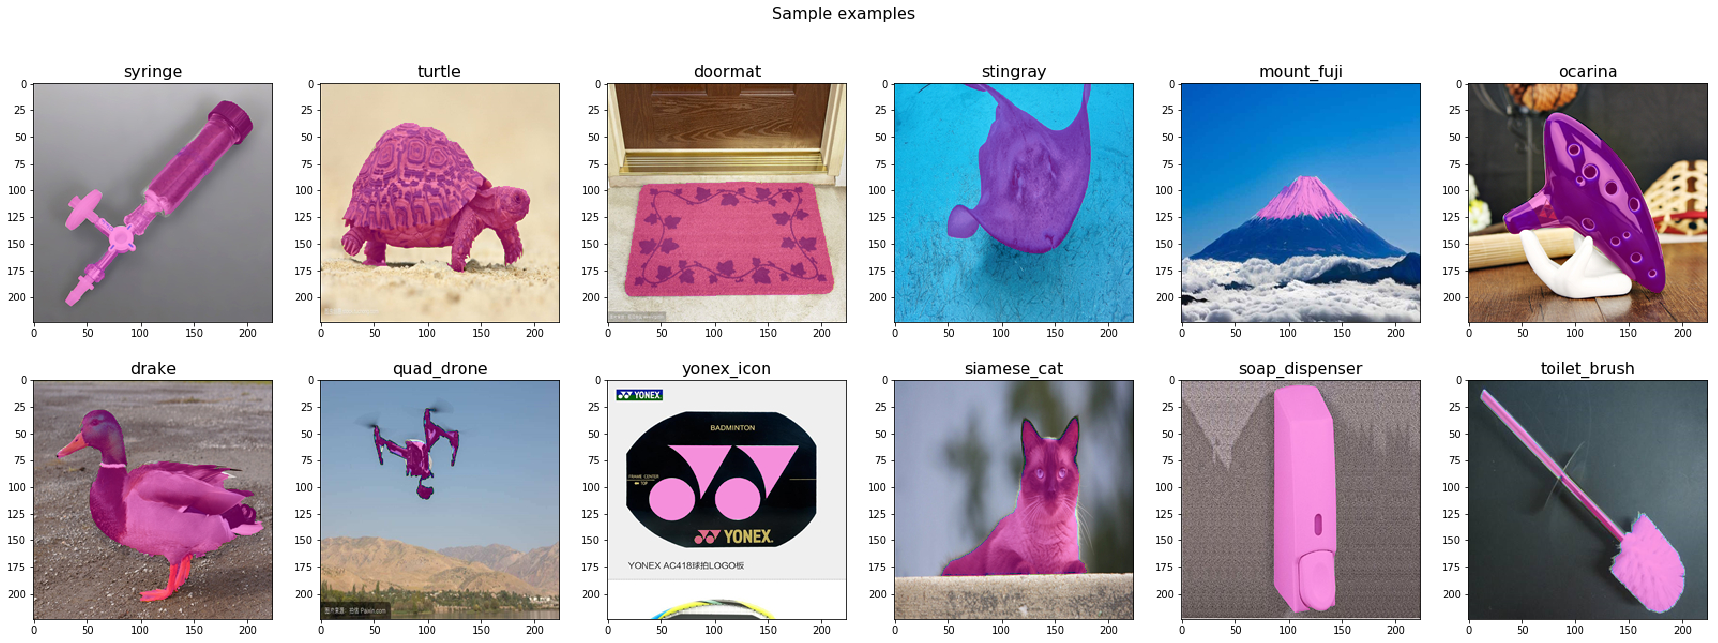

In [87]:
ncols = 6
nrows = 2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5, nrows*5))
fig.suptitle('Sample examples', fontsize=16)
ax = ax.flatten()

for idx, (_, sample) in enumerate(final_df.sample(ncols*nrows).iterrows()):
    img = cv2.imread(sample.in_file)
    mask = cv2.imread(sample.out_file, cv2.IMREAD_GRAYSCALE)
    ax[idx].imshow(img[:, :, ::-1])
    ax[idx].imshow(mask, cmap='rainbow_alpha', alpha=0.4)
    ax[idx].set_title(sample['class'], fontsize=16)

## Extract bounding box features

In [109]:
def bounding_box_from_mask(df_row):
    mask = cv2.imread(df_row['out_file'], cv2.IMREAD_GRAYSCALE)
    mask[mask > 127] = 255
    mask[mask <= 127] = 0
    mask_coordinates = np.where(mask == 255)
    
    x_min = np.min(mask_coordinates[1])/mask.shape[1]
    x_max = np.max(mask_coordinates[1])/mask.shape[1]
    
    y_min = np.min(mask_coordinates[0])/mask.shape[0]
    y_max = np.max(mask_coordinates[0])/mask.shape[0]
    
    x_center = np.mean([x_min, x_max])
    y_center = np.mean([y_min, y_max])
    
    return x_min, y_min, x_max, y_max, x_center, y_center

bb_features = final_df.apply(bounding_box_from_mask, axis=1)

Add features to DataFrame

In [110]:
final_df['x_min'] = list(map(operator.itemgetter(0), bb_features))
final_df['y_min'] = list(map(operator.itemgetter(1), bb_features))
final_df['x_max'] = list(map(operator.itemgetter(2), bb_features))
final_df['y_max'] = list(map(operator.itemgetter(3), bb_features))
final_df['x_center'] = list(map(operator.itemgetter(4), bb_features))
final_df['y_center'] = list(map(operator.itemgetter(5), bb_features))

final_df.sample(5)

class                  in_file                 out_file     x_min  \
4      beacon      ./Data/beacon/3.jpg      ./Data/beacon/3.png  0.830357   
4  box_turtle  ./Data/box_turtle/3.jpg  ./Data/box_turtle/3.png  0.044643   
5     siamang     ./Data/siamang/1.jpg     ./Data/siamang/1.png  0.191964   
4    gas_pump    ./Data/gas_pump/3.jpg    ./Data/gas_pump/3.png  0.419643   
7  vine_snake  ./Data/vine_snake/8.jpg  ./Data/vine_snake/8.png  0.281250   

      y_min     x_max     y_max  x_center  y_center  
4  0.263393  0.901786  0.504464  0.866071  0.383929  
4  0.196429  0.910714  0.803571  0.477679  0.500000  
5  0.120536  0.852679  0.861607  0.522321  0.491071  
4  0.290179  0.593750  0.794643  0.506696  0.542411  
7  0.281250  0.995536  0.839286  0.638393  0.560268

## Validate bounding box features

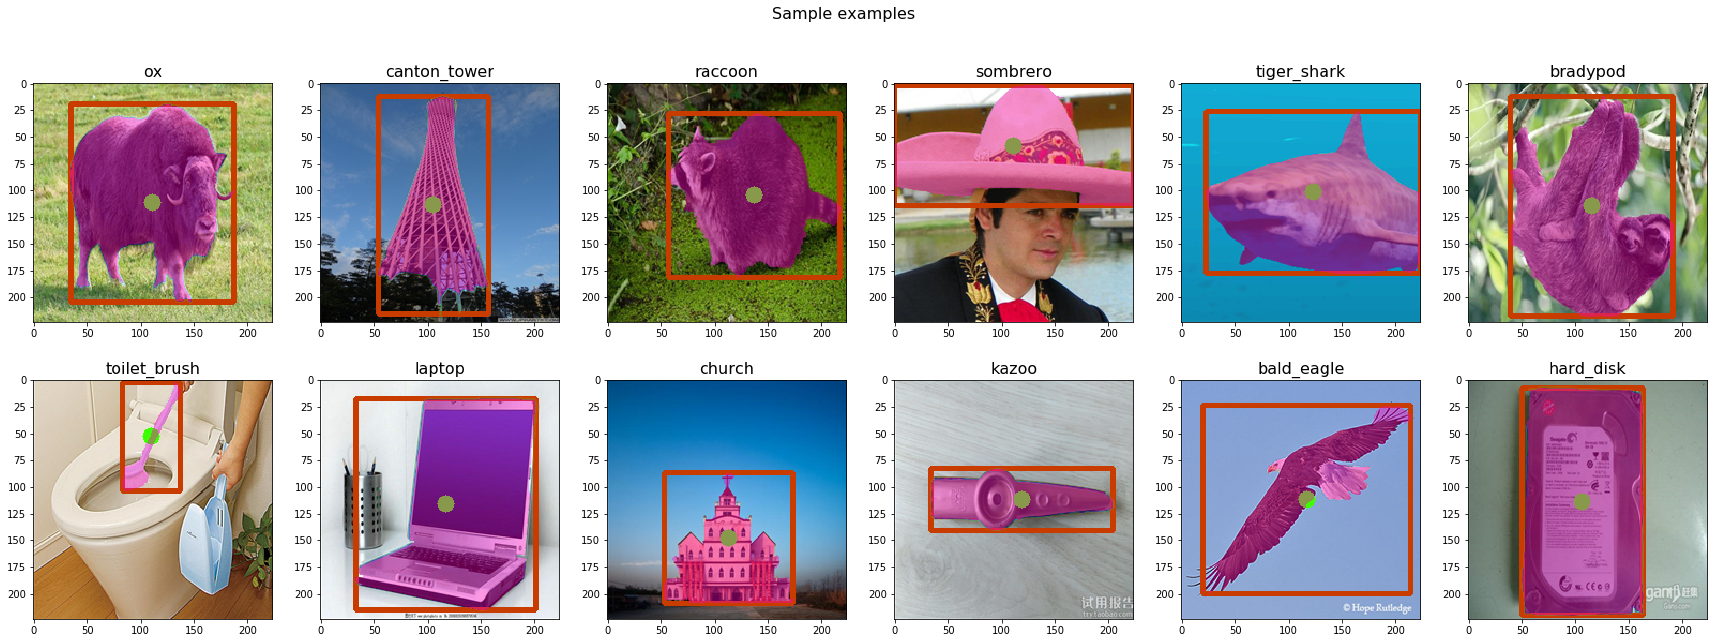

In [108]:
ncols = 6
nrows = 2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5, nrows*5))
fig.suptitle('Sample examples', fontsize=16)
ax = ax.flatten()

for idx, (_, sample) in enumerate(final_df.sample(ncols*nrows).iterrows()):
    img = cv2.imread(sample.in_file)
    mask = cv2.imread(sample.out_file, cv2.IMREAD_GRAYSCALE)
    
    w = img.shape[1]
    h = img.shape[0]
    
    pt1 = (int(sample.x_min*w), int(sample.y_min*h))
    pt2 = (int(sample.x_max*w), int(sample.y_max*h))
    center = (int(sample.x_center*w), int(sample.y_center*h))
    img = cv2.rectangle(img, pt1, pt2, (0, 60, 200), 4)
    img = cv2.circle(img, center, 8, (0, 255, 60), cv2.FILLED)
    
    ax[idx].imshow(img[:, :, ::-1])
    ax[idx].imshow(mask, cmap='rainbow_alpha', alpha=0.4)
    ax[idx].set_title(sample['class'], fontsize=16)

## Extract bounding box width & height

In [113]:
final_df['width'] = final_df.apply(lambda r: r.x_max-r.x_min, axis=1)
final_df['height'] = final_df.apply(lambda r: r.y_max-r.y_min, axis=1)
final_df.sample(5)

class                   in_file                  out_file     x_min  \
6    turnstile    ./Data/turnstile/2.jpg    ./Data/turnstile/2.png  0.058036   
5      jacamar      ./Data/jacamar/1.jpg      ./Data/jacamar/1.png  0.245536   
4      sundial      ./Data/sundial/3.jpg      ./Data/sundial/3.png  0.040179   
8  timber_wolf  ./Data/timber_wolf/9.jpg  ./Data/timber_wolf/9.png  0.102679   
3       weasel       ./Data/weasel/7.jpg       ./Data/weasel/7.png  0.053571   

      y_min     x_max     y_max  x_center  y_center     width    height  
6  0.125000  0.861607  0.977679  0.459821  0.551339  0.803571  0.852679  
5  0.165179  0.799107  0.839286  0.522321  0.502232  0.553571  0.674107  
4  0.000000  0.910714  0.924107  0.475446  0.462054  0.870536  0.924107  
8  0.125000  0.901786  0.941964  0.502232  0.533482  0.799107  0.816964  
3  0.254464  0.888393  0.848214  0.470982  0.551339  0.834821  0.593750

## Validate bounding box width & height

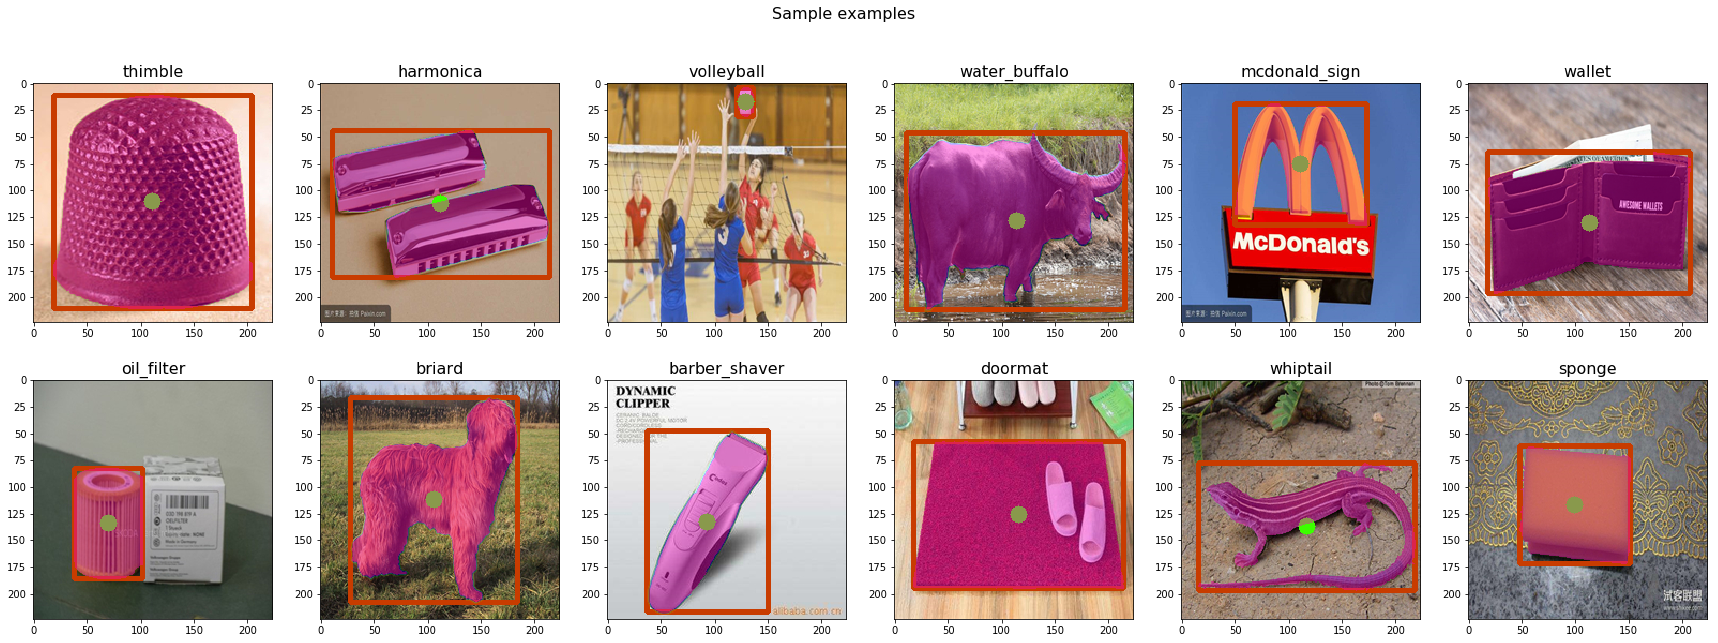

In [116]:
ncols = 6
nrows = 2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5, nrows*5))
fig.suptitle('Sample examples', fontsize=16)
ax = ax.flatten()

for idx, (_, sample) in enumerate(final_df.sample(ncols*nrows).iterrows()):
    img = cv2.imread(sample.in_file)
    mask = cv2.imread(sample.out_file, cv2.IMREAD_GRAYSCALE)
    
    w = img.shape[1]
    h = img.shape[0]
    
    center = (int(sample.x_center*w), int(sample.y_center*h))
    pt1 = (int((sample.x_center-sample.width/2)*w), int((sample.y_center-sample.height/2)*h))
    pt2 = (int((sample.x_center+sample.width/2)*w), int((sample.y_center+sample.height/2)*h))
    img = cv2.rectangle(img, pt1, pt2, (0, 60, 200), 4)
    img = cv2.circle(img, center, 8, (0, 255, 60), cv2.FILLED)
    
    ax[idx].imshow(img[:, :, ::-1])
    ax[idx].imshow(mask, cmap='rainbow_alpha', alpha=0.4)
    ax[idx].set_title(sample['class'], fontsize=16)

In [127]:
ids, names = pd.factorize(final_df['class'].unique())
name_to_id_dict = dict(zip(names, ids))
final_df['class_id'] = final_df.apply(lambda r: name_to_id_dict[r['class']], axis=1)
final_df.sample(5)

class                      in_file                     out_file  \
6  border_terrier  ./Data/border_terrier/2.jpg  ./Data/border_terrier/2.png   
8      solar_dish      ./Data/solar_dish/9.jpg      ./Data/solar_dish/9.png   
4          rabbit          ./Data/rabbit/3.jpg          ./Data/rabbit/3.png   
5          mitten          ./Data/mitten/1.jpg          ./Data/mitten/1.png   
6          eggnog          ./Data/eggnog/2.jpg          ./Data/eggnog/2.png   

      x_min     y_min     x_max     y_max  x_center  y_center     width  \
6  0.013393  0.232143  0.973214  0.790179  0.493304  0.511161  0.959821   
8  0.151786  0.102679  0.870536  0.919643  0.511161  0.511161  0.718750   
4  0.290179  0.066964  0.857143  0.995536  0.573661  0.531250  0.566964   
5  0.241071  0.191964  0.772321  0.901786  0.506696  0.546875  0.531250   
6  0.357143  0.276786  0.790179  0.763393  0.573661  0.520089  0.433036   

     height  class_id  
6  0.558036       427  
8  0.816964        80  
4  0.928571       916  
5  0.709821       727  
6  0.486607       250

In [128]:
final_df.to_csv('./Data/fewshots.csv')